# SWiFT Multifile
Demonstration of some of the mmctools functions and standards for postprocessing WRF-LES output <br>
Also includes examples of MMC spectra and correlation lengthscale functions.

#############################################################################

## Preamble
Set file paths, enter physical constants, import modules, etc...

### Import modules

In [1]:
import glob
import os, re

# Well-known python modules (i.e, available through conda)

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

import glob
import os
import sys

# Less well-known

import wrf #as wrf

#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
#if module_path not in sys.path:
#    sys.path.append(module_path)
import mmctools

### Physical constants and other parameters

In [2]:
g = 9.81 #[m/s/s], gravitational constant

### User-defined functions

In [3]:
########################
# Postprocess WRF output
########################
#
#
#    The purpose of this function is to take the DataSet that is produced from an xarray 'open_mfdataset'
#         function call and to modify it to work well with mmctools functions. This includes:
#               -Renaming dimensions and coordinates to code standards
#               -Computing 1-D Z [m] variable and assigning it as a coordinate
#               -Destaggering winds
#               -Returns only the requested variables (optional)
#               -Truncates the simulation output at some height (optional)

def postprocess_wrf_outout( ds, variable_list = ['U', 'V', 'W', 'T', 'UST'], z_max = None ):
    '''
    Changes coordinate, dimension, and variable names, computes z, destaggers wind fields.
        ds: Xarray Dataset. Default from open_mfdataset on all WRF variables
        
            
        z_max: maximum z (float). If defined, any model output above this height will be truncated. Default is None.
    '''
    
    # Rename dims, and drop XLAT/XLONG coords (since they're all 0 for an idealized run)
    print("Renaming dims...")
    ds = ds.rename_dims( {'west_east': 'nx', 'south_north': 'ny', 'bottom_top': 'nz',
                'west_east_stag': 'nx_stag', 'south_north_stag': 'ny_stag', 'bottom_top_stag': 'nz_stag'})

    ds = ds.drop(['XLAT','XLONG','XLAT_U','XLONG_U','XLAT_V','XLONG_V'])
    
    # Compute x, y, and z. Assign as coords.
    print("Computing x, and y...")
    ds['x'] = ds.nx * ds.DX
    ds['y'] = ds.ny * ds.DY

    print('...and now z...')

    ds['z_stag_4D'] = ( ds.PH + ds.PHB) / g
    ds['z_stag_1D'] = ds.z_stag_4D.mean(dim = ('nx', 'ny', 'Time') )
    z1D = (ds.z_stag_1D.values[:-1] + \
           ds.z_stag_1D.values[1:] ) / 2.
    ds['z1D'] = xr.DataArray( z1D, dims = 'nz' )

    print("Assigning coords...")
    ds  =  ds.assign_coords({'x': ds.x, 'y': ds.y, 'z': ds.z1D})
    
    # Truncate above z_max
    if z_max is not None:
        print(f"z_max is defined, truncating above {z_max} m")
        z_ind = np.where( ds.z1D > z_max )
        #print(z_ind)
        if len(z_ind) == 0:
            print(f"z_max = {z_max} is higher than model top")
            print("continuing")
        else:
            z_ind = z_ind[0][0]
            #print(z_ind)
            ds = ds.isel(nz = slice(0,z_ind + 1), nz_stag =slice(0,z_ind + 2) )
            print(f"Grid cells above {z_max} discarded")
    
    else:
        print("z_max is none, processing entire domain")
        
    print("destaggering winds...")
    ds = ds.rename({'U': 'U_stag', 'V': 'V_stag', 'W': 'W_stag'})
    print('...U...')
    ds['U'] = wrf.destagger( ds.U_stag, stagger_dim = 3, meta = True)
    print('...V...')
    ds['V'] = wrf.destagger( ds.V_stag, stagger_dim = 2, meta = True)
    print('...and now W...')
    ds['W'] = wrf.destagger( ds.W_stag, stagger_dim = 1, meta = True)
    
    # Grab only variables of interest
    if variable_list is not None:
        print("variables_list is defined, grabbing only these variables")
        data_variables = {}
        for v in variable_list:
            data_variables[v] = ds[v]
        ds = xr.Dataset( data_vars = data_variables, coords = ds.coords)
    else:
        print("Including all variables")
    
    return ds


    

In [4]:
########################
# calc_mean_pert
########################
# Calculate bar and prime (mean and perturbation) quantities
#

def calc_mean_pert( ds, variable_list = ['U', 'V', 'W'], mean_wind_dir = 'periodic',  ):
    '''
    Purpose of this function is to compute the mean and perturbation quantities for computing fluxes and stresses.
    
        ds: xarray Dataset. Contains the coords, dims, and variables (U,V,W) 
            that have been computed by the postprocessing function above
        variable_list: array-like. Contains variable names (strings) for mean/perturbation quantities.
            Must be 4-D variables using x/y/z coords, error-catches are not implemented.
        mean_wind_dir: either 'periodic' (default) or 'zonal' (i.e. mean wind dir is from west to east).
            periodic: compute means on x/y planes to get mean quantities as a function of time and height
            zonal: mean quantities will be computed on lines of constant x, so mean will also be a function of x.
                this means less statistical power, and some temporal averaging may be required, but that is not
                accounted for in this function (yet)
    '''
    
    mean_str_suff = '_bar'
    pert_str_suff = '_p'
    
    for vv in variable_list:
        print(vv)
        mean_str = vv + mean_str_suff
        pert_str = vv + pert_str_suff
        
        if mean_wind_dir == 'periodic':
            print("Periodic simulation")
            ds[mean_str] = ds[vv].mean(dim = ('nx', 'ny'))
            ds[pert_str] = ds[vv] - ds[mean_str]
        elif mean_wind_dir == 'zonal':
            print("Zonal simulation, may need some temporal averaging for power")
            ds[mean_str] = ds[vv].mean(dim = ('nx'))
            ds[pert_str] = ds[vv] - ds[mean_str]
    return ds
    

In [5]:
########################
# calc_stresses
########################
# Calculate stress terms
#

def calc_stresses( ds, do_uw = True, do_vw = False, do_uv = False):
    '''
    Calculate components of the Stress-Energy tensor relevant to shear production of turbulence
        ds: xarray dataset.
        do_uw: Boolean (default True). If true, calculates tau13 (the u'w' component of the stress energy tensor)
        do_vw: Boolean (default False). If true, calculates tau23 (the u'w' component of the stress energy tensor)
        do_uv: Boolean (default False). If true, calculates tau12 (the u'w' component of the stress energy tensor)
    '''
    if do_uw:
        print('calculating tau13...')
        ds['tau13'] = ( ds.U_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_vw:
        print('calculating tau23...')
        ds['tau23'] = ( ds.V_p * ds.W_p ).mean(dim = ('nx', 'ny'))
    if do_uv:
        print('calculating tau12...')
        ds['tau12'] = ( ds.U_p * ds.V_p ).mean(dim = ('nx', 'ny'))
        
    return ds
    

In [6]:
########################
# calc_tke
########################
# Calculate resolved TKE
#

def calc_tke( ds ):
    '''
    Calculates RESOLVE LES TKE. Does not compute the subgrid component.
        ds: xarray dataset.
    '''
    print("calculating TKE...")
    ds['TKE'] = 1./2. * (  ( ds.U_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.V_p**2. ).mean(dim = ('nx', 'ny') ) \
                         + ( ds.W_p**2. ).mean(dim = ('nx', 'ny') ) )
    
    return ds

### File paths and file names

In [7]:
#Extracting folder names

path='/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/'
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
fname_stem = 'wrfout_d01_0001-01-02_00*'

DX=[]
DZ=[]
ALPHA=[]

for filename in os.listdir(path):
    if filename.startswith('DX'):
        dx = re.findall("DX_(\d+)_DZ", filename)
        DX.append(int(dx[0]))
        # initializing substrings
        sub1 = "DZ_"
        sub2 = "_ALPHA"
        idx1 = filename.index(sub1)
        idx2 = filename.index(sub2)
        dz = ''
        for idx in range(idx1 + len(sub1), idx2):
            dz = dz + filename[idx]
        DZ.append(dz)
        ALPHA.append(str(round(np.int(dx[0])/np.int(dz[0]),1)))
        


In [8]:
folder='DX_36_DZ_18.0_ALPHA_2.0'
path + folder + '/' + fname_stem

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00*'

In [9]:
#Example of searching on LC

!ls /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00*

/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:00:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:10:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:20:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:30:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:40:00
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0/wrfout_d01_0001-01-02_00:50:00


## Actual analysis begins (Load 4-D model output and Compute Spectra of each file)

In [ ]:
#Single file for testing

'''

folder='DX_6_DZ_2.0_ALPHA_3.0'
simulation_loc=f'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/{folder}/'
pdata_3D = f'pdata_3D_{folder}.nc'
pdata_spectra = f'pdata_spectra_{folder}.nc'
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'

if os.path.exists(simulation_loc + fname_stem[:-1] +':00:00'):
    print('exits')

flist = glob.glob( path + folder + '/' + fname_stem )
flist.sort()

save_pdata = True

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists")
                ds = xr.open_dataset( pdata_loc + pdata_3D )
else:
    print("Process data does not exist, reading from WRFOUT")
    ds = xr.open_mfdataset( flist, \
                           chunks = {'Time':10},
                           combine = 'nested',
                           concat_dim = 'Time'  )
    ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
    ds = calc_mean_pert( ds )
    ds = calc_stresses( ds )
    ds = calc_tke( ds )
    if save_pdata:
        print("Saving pdata...")
        ds.to_netcdf(pdata_loc + pdata_3D)
        save_spectra_pdata = True


if os.path.exists(pdata_loc + pdata_spectra):
    print("Spectra process data exists")
    psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
else:
    from mmctools.helper_functions import calc_spectra

    print("Spectra process data missing, calculating")
    ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
    psd_list = []
    NT = len(ds.Time)
    for tt in range(0,NT):
        print(f"Time {tt} of {NT}")
        psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                            var_oi=['U_p','W_p'],\
                            spectra_dim='ny',\
                            #average_dim='XTIME',\
                            average_dim='nx',\
                            level_dim='nz',
                            level = [5, 15, 25, 29]\
                             )

        psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

    psd_ds = xr.concat( psd_list, "Time" )
    psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

    psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 29]].values, dims = 'nz' )

    if save_spectra_pdata:
        print("Saving spectra process data")
        psd_ds.to_netcdf( pdata_loc + pdata_spectra )

'''

In [20]:
cd /p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0/

/p/lustre2/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_6_DZ_3.0_ALPHA_2.0


In [25]:
#Test
path + folder + '/' + fname_stem[:-1]

'/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_18.0_ALPHA_2.0/wrfout_d01_0001-01-02_00'

In [48]:
# Processing and saving all files 

'''
for dx in DX:
    for dz in DZ:
        alpha=str(round(dx/float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            print("Process data exists, working on folder:")
            print(path + folder)
            pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            pdata_spectra = f'pdata_spectra_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            if os.path.exists(path + folder + '/' + fname_stem[:-1] +':00:00'):
                print(f'{fname_stem} exits')
                try:
                    flist = glob.glob( path + folder + '/' + fname_stem)
                    flist.sort()
                    # Use xarray.open_mfdataset. https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html

                    save_pdata = True

                    if os.path.exists(pdata_loc + pdata_3D):
                        print("Process data exists")
                        ds = xr.open_dataset( pdata_loc + pdata_3D )
                    else:
                        print("Process data does not exist, reading from WRFOUT")
                        ds = xr.open_mfdataset( flist, \
                                               chunks = {'Time':10},
                                               combine = 'nested',
                                               concat_dim = 'Time'  )
                        ds = postprocess_wrf_outout( ds, z_max = 1100 ) #No subgrid stress/TKE components
                        ds = calc_mean_pert( ds )
                        ds = calc_stresses( ds )
                        ds = calc_tke( ds )
                        if save_pdata:
                            print("Saving pdata...")
                            ds.to_netcdf(pdata_loc + pdata_3D)
                            save_spectra_pdata = True


                    if os.path.exists(pdata_loc + pdata_spectra):
                        print("Spectra process data exists")
                        #psd_ds = xr.open_dataset( pdata_loc + pdata_spectra )
                    else:
                        from mmctools.helper_functions import calc_spectra

                        print("Spectra process data missing, calculating")
                        ds2 = ds.assign_coords( {'nx' : ds.nx, 'ny' : ds.ny, 'nz' : ds.nz, 'Time' : ds.Time})
                        psd_list = []
                        NT = len(ds.Time)
                        for tt in range(0,NT):
                            print(f"Time {tt} of {NT}")
                            psd_hr1_temp = calc_spectra( ds2.isel(Time = tt),\
                                                var_oi=['U_p','W_p'],\
                                                spectra_dim='ny',\
                                                #average_dim='XTIME',\
                                                average_dim='nx',\
                                                level_dim='nz',
                                                level = [5, 15, 25, 35] \
                                                 )

                            psd_list.append(psd_hr1_temp.mean(dim = 'nx'))

                        psd_ds = xr.concat( psd_list, "Time" )
                        psd_ds = psd_ds.assign_coords({"Time": ds.Time, "XTIME": ds.XTIME})

                        psd_ds['z'] = xr.DataArray( ds.z[[5, 15, 25, 35]].values, dims = 'nz' )

                        if save_spectra_pdata:
                            print("Saving spectra process data")
                            psd_ds.to_netcdf( pdata_loc + pdata_spectra )
                except OSError:
                    print('Passing, permission denied ...')
                    pass
                    
'''

Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_4.0_ALPHA_3.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_12_DZ_6.0_ALPHA_2.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_4.5_ALPHA_4.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_18_DZ_6.0_ALPHA_3.0
wrfout_d01_0001-01-02_00* exits
Process data exists
Spectra process data exists


# Resample to hourly means
Requires playing with some dimension names surrounding Time

In [21]:
#Run next cell if you want to obtain all the files. Run this one if you want to obtail a s ingle file only

'''
pdata_loc = '/g/g92/mgf/Scratch1/Wind_Energy/Will/Data/'
folder='DX_24_DZ_3.0_ALPHA_8.0'
pdata_3D = f'pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc'
pdata_spectra = f'pdata_spectra_DX_24_DZ_3.0_ALPHA_8.0.nc'

if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds=xr.open_dataset( pdata_loc + pdata_3D )
                psd_ds=xr.open_dataset( pdata_loc + pdata_spectra )
                ds = ds.swap_dims({'Time': 'XTIME'})
                ds_1hr=ds.resample({'XTIME':'1H'}).mean()
                psd_ds= psd_ds.swap_dims({'Time': 'XTIME'})
                psd_ds_1hr = psd_ds.resample({'XTIME':'1H'}).mean()

'''

Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc


In [26]:
# Processing all files, omitting the already processed ones

'''

ds=[]
psd_ds=[]
ds_1hr=[]
psd_ds_1hr=[]
case=[]

DX=[36,12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['4.0', '4.5', '6.0', '3.0', '12.0', '10.0', '8.0', '9.0', '18.0', '15.0', '5.0', '7.2', '2.0', '7.5', '2.4']

for dx in DX:
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        print('DX= ',dx)
        print('DZ= ',dz)
        print('ALPHA=',alpha)
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        print(folder)
        if os.path.exists(path+folder):
            print("Process data exists, working on folder:")
            print(path + folder)
            pdata_3D = f'pdata_3D_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            pdata_spectra = f'pdata_spectra_DX_{dx}_DZ_{dz}_ALPHA_{alpha}.nc'
            if os.path.exists(pdata_loc + pdata_3D):
                print("Process data exists",pdata_loc + pdata_3D)
                ds.append(xr.open_dataset( pdata_loc + pdata_3D ))
                psd_ds.append(xr.open_dataset( pdata_loc + pdata_spectra ))
                ds[-1] = ds[-1].swap_dims({'Time': 'XTIME'})
                ds_1hr.append(ds[-1].resample({'XTIME':delta_t}).mean())
                psd_ds[-1] = psd_ds[-1].swap_dims({'Time': 'XTIME'})
                psd_ds_1hr.append(psd_ds[-1].resample({'XTIME':delta_t}).mean())
                case.append(folder)
        else:
            print("Processed data does not exist, reading from WRFOUT")
'''

DX=  36
DZ=  4.0
ALPHA= 9.0
DX_36_DZ_4.0_ALPHA_9.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.0_ALPHA_9.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_36_DZ_4.0_ALPHA_9.0.nc
DX=  36
DZ=  4.5
ALPHA= 8.0
DX_36_DZ_4.5_ALPHA_8.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_4.5_ALPHA_8.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_36_DZ_4.5_ALPHA_8.0.nc
DX=  36
DZ=  6.0
ALPHA= 6.0
DX_36_DZ_6.0_ALPHA_6.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_36_DZ_6.0_ALPHA_6.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_36_DZ_6.0_ALPHA_6.0.nc
DX=  36
DZ=  3.0
ALPHA= 12.0
DX_36_DZ_3.0_ALPHA_12.0
Processed data does not exist, reading from WRFOUT
DX=  36
DZ=  12.0
ALPHA= 3.0
DX_36_DZ_12.0_ALPHA_3.0
Process data exists, workin

DX=  24
DZ=  4.5
ALPHA= 5.3
DX_24_DZ_4.5_ALPHA_5.3
Processed data does not exist, reading from WRFOUT
DX=  24
DZ=  6.0
ALPHA= 4.0
DX_24_DZ_6.0_ALPHA_4.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_6.0_ALPHA_4.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_24_DZ_6.0_ALPHA_4.0.nc
DX=  24
DZ=  3.0
ALPHA= 8.0
DX_24_DZ_3.0_ALPHA_8.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_3.0_ALPHA_8.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_24_DZ_3.0_ALPHA_8.0.nc
DX=  24
DZ=  12.0
ALPHA= 2.0
DX_24_DZ_12.0_ALPHA_2.0
Process data exists, working on folder:
/p/lscratchh/mirocha2/ML_LES_DX/LZ_2880_LZ_1800_UG_10_Z0_0.1/DX_24_DZ_12.0_ALPHA_2.0
Process data exists /g/g92/mgf/Scratch1/Wind_Energy/Will/Data/pdata_3D_DX_24_DZ_12.0_ALPHA_2.0.nc
DX=  24
DZ=  10.0
ALPHA= 2.4
DX_24_DZ_10.0_ALPHA_2.4
Processed data does not e

In [27]:
#Saving time average files

'''
for i in range(len(ds_1hr)):
    if os.path.exists(pdata_loc + f'time_average_3D_{delta_t}_{case[i]}.nc'):
        print(f'{case[i]} 3D time average exits')
    else:    
        ds_1hr[i].to_netcdf(pdata_loc + f'time_average_3D_{delta_t}_{case[i]}.nc')
    if os.path.exists(pdata_loc + f'time_average_spectra_{delta_t}_{case[i]}.nc'):
        print(f'{case[i]} spectra time average exits')
    else:
        psd_ds_1hr[i].to_netcdf(pdata_loc + f'time_average_spectra_{delta_t}_{case[i]}.nc')
        
'''


DX_36_DZ_4.0_ALPHA_9.0 3D time average exits
DX_36_DZ_4.0_ALPHA_9.0 spectra time average exits
DX_36_DZ_4.5_ALPHA_8.0 3D time average exits
DX_36_DZ_4.5_ALPHA_8.0 spectra time average exits
DX_36_DZ_6.0_ALPHA_6.0 3D time average exits
DX_36_DZ_6.0_ALPHA_6.0 spectra time average exits
DX_36_DZ_12.0_ALPHA_3.0 3D time average exits
DX_36_DZ_12.0_ALPHA_3.0 spectra time average exits
DX_36_DZ_8.0_ALPHA_4.5 3D time average exits
DX_36_DZ_8.0_ALPHA_4.5 spectra time average exits
DX_36_DZ_9.0_ALPHA_4.0 3D time average exits
DX_36_DZ_9.0_ALPHA_4.0 spectra time average exits
DX_36_DZ_18.0_ALPHA_2.0 3D time average exits
DX_36_DZ_18.0_ALPHA_2.0 spectra time average exits
DX_36_DZ_7.2_ALPHA_5.0 3D time average exits
DX_36_DZ_7.2_ALPHA_5.0 spectra time average exits
DX_12_DZ_4.0_ALPHA_3.0 3D time average exits
DX_12_DZ_4.0_ALPHA_3.0 spectra time average exits
DX_12_DZ_6.0_ALPHA_2.0 3D time average exits
DX_12_DZ_6.0_ALPHA_2.0 spectra time average exits
DX_12_DZ_3.0_ALPHA_4.0 3D time average exits
D

In [177]:
ds_1hr=[]
psd_ds_1hr=[]

import os
prefixed1 = [filename for filename in os.listdir(pdata_loc) if filename.startswith("time_average_3D")]
prefixed2 = [filename for filename in os.listdir(pdata_loc) if filename.startswith("time_average_spectra")]

for i in range(len(prefixed1)):
    ds_1hr.append(xr.open_dataset(pdata_loc + prefixed1[i]))
    psd_ds_1hr.append(xr.open_dataset(pdata_loc + prefixed2[i]))

# Some plots

In [30]:
#Number of hours considered, in our case just the first hour
NT_hr = len( ds_1hr[0].XTIME )

### Vertical profiles

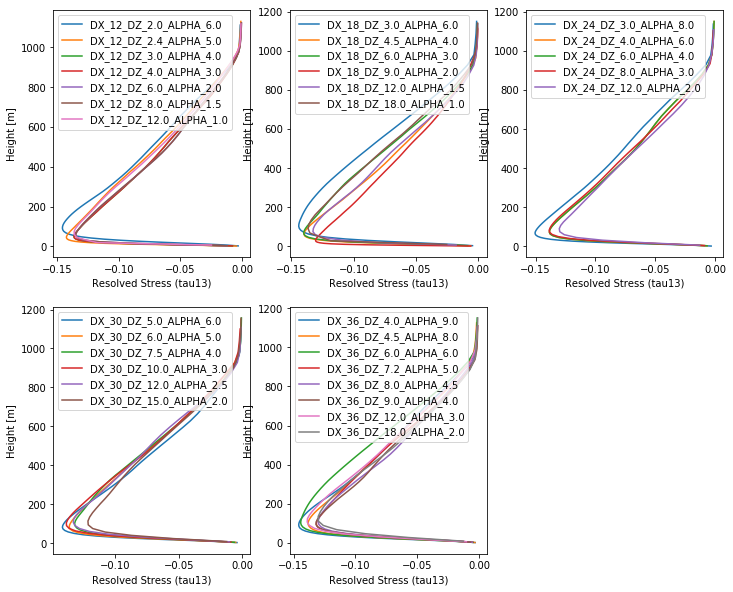

In [89]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )



DX=[12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

case=[]
p=0
q=0
for dx in DX:
    p=p+1
    plt.subplot(2,3,p)
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).tau13, img.z , label=f'{folder}' )
                plt.legend()
                plt.xlabel('Resolved Stress (tau13)')
                plt.ylabel('Height [m]')



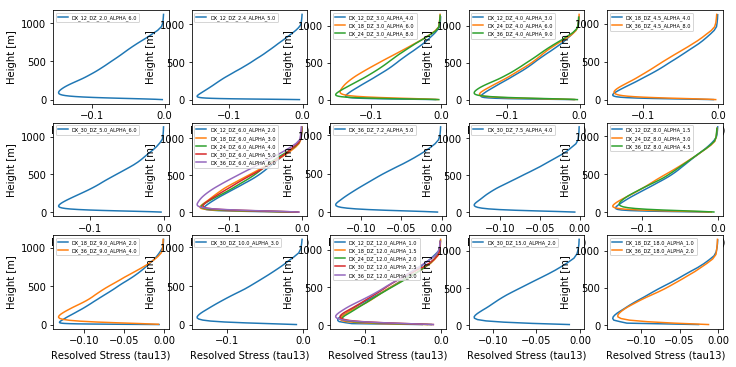

In [94]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )



DX=[12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

case=[]
p=0
q=0

for dz in DZ:
    p=p+1
    plt.subplot(5,5,p)
    for dx in DX:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).tau13, img.z , label=f'{folder}' )
                plt.legend(fontsize=5)
                plt.xlabel('Resolved Stress (tau13)')
                plt.ylabel('Height [m]')


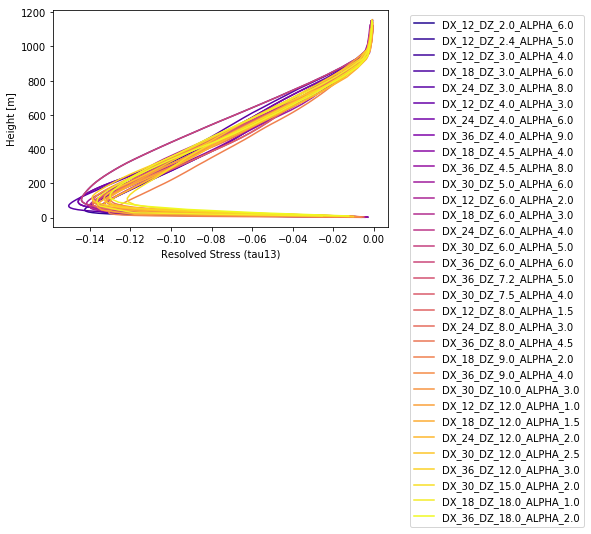

In [127]:
# Tau13 vertical profile, color a function of cases (one hour average)

#Setting colormaps
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )
case_colormap = plt.cm.plasma(np.linspace(0, 1, len(ds_1hr)) )

case=[]
p=0
q=0

for dz in DZ:
    p=p+1
    for dx in DX:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).tau13, img.z , c=case_colormap[q], label=f'{folder}' )
                plt.xlabel('Resolved Stress (tau13)')
                plt.ylabel('Height [m]')

ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
plt.legend(bbox_to_anchor=(1.05, 1))


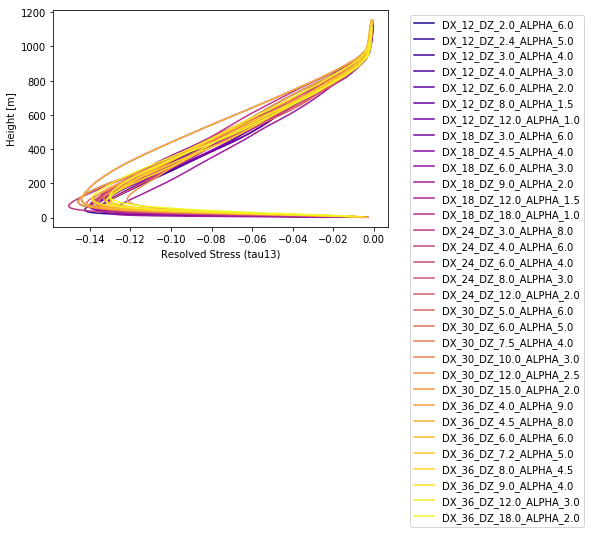

In [128]:
# Tau13 vertical profile, color a function of cases (one hour average)

#Setting colormaps
time_colormap = plt.cm.plasma(np.linspace(0, 1, NT_hr) )
case_colormap = plt.cm.plasma(np.linspace(0, 1, len(ds_1hr)) )

case=[]
p=0
q=0

for dx in DX:
    p=p+1
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).tau13, img.z , c=case_colormap[q], label=f'{folder}' )
                plt.xlabel('Resolved Stress (tau13)')
                plt.ylabel('Height [m]')

ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
plt.legend(bbox_to_anchor=(1.05, 1))


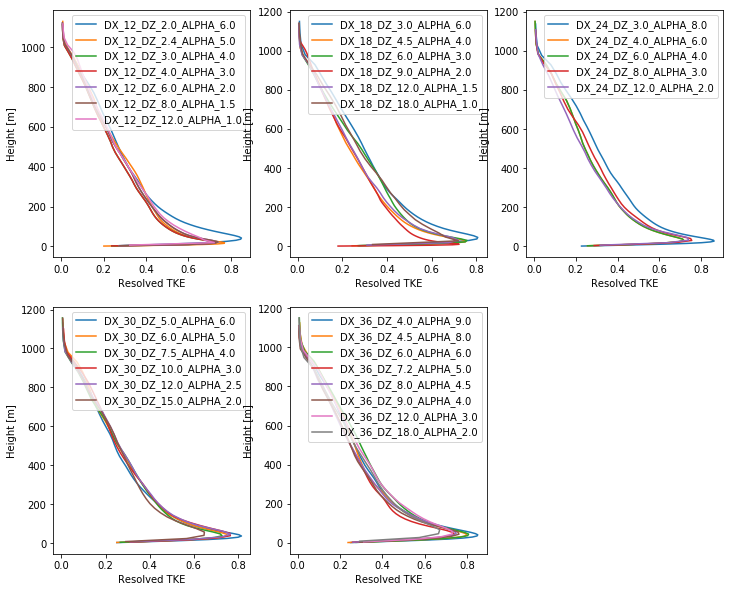

In [135]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )



DX=[12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

case=[]
p=0
q=0
for dx in DX:
    p=p+1
    plt.subplot(2,3,p)
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).TKE, img.z , label=f'{folder}' )
                plt.legend()
                plt.xlabel('Resolved TKE')
                plt.ylabel('Height [m]')



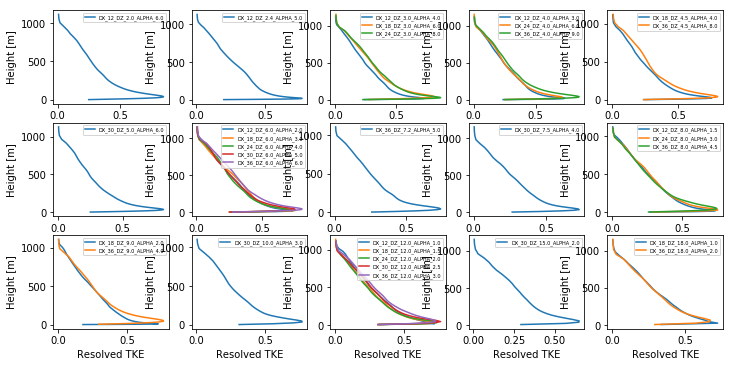

In [136]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )



DX=[12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

case=[]
p=0
q=0

for dz in DZ:
    p=p+1
    plt.subplot(5,5,p)
    for dx in DX:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_3D_{delta_t}_{folder}.nc')
                plt.plot(img.isel(XTIME = 0).TKE, img.z , label=f'{folder}' )
                plt.legend(fontsize=5)
                plt.xlabel('Resolved TKE')
                plt.ylabel('Height [m]')


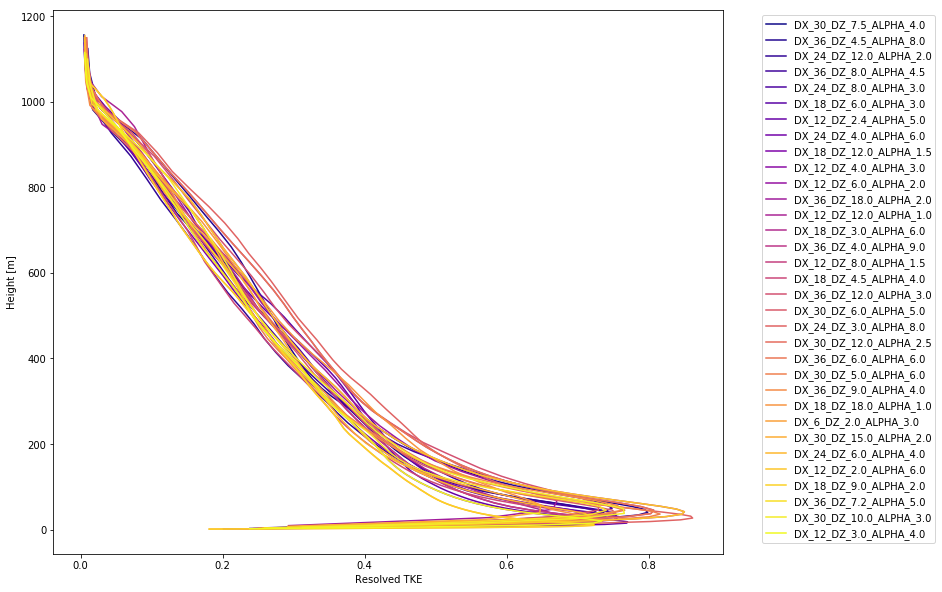

In [130]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(ds_1hr)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{prefixed1[tt][19:-3]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
plt.legend(bbox_to_anchor=(1.05, 1))

(0.0, 200)

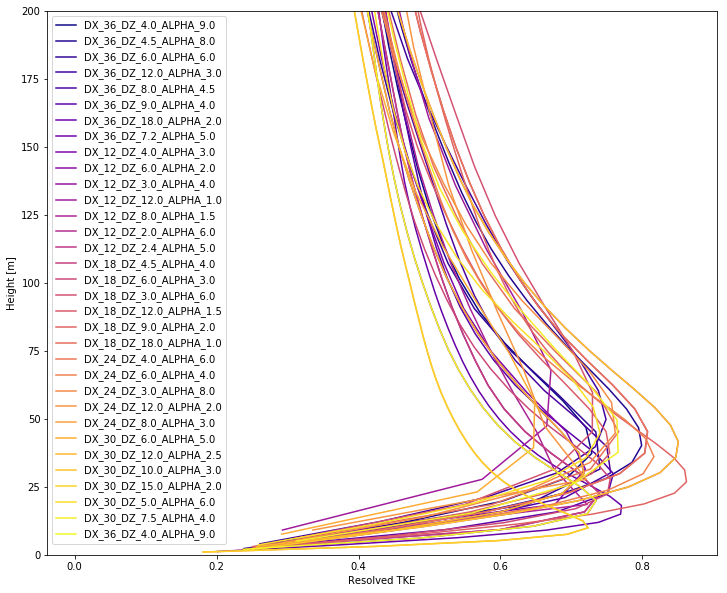

In [35]:
# TKE vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

for tt in range(0, len(ds_1hr)): 
    ax.plot( ds_1hr[tt].isel(XTIME = 0).TKE, ds_1hr[tt].z , c = case_colormap[tt], label=f'{case[tt]}')
    
ax.set_xlabel('Resolved TKE')
ax.set_ylabel('Height [m]')
ax.legend()

ax.set_ylim([0., 200])

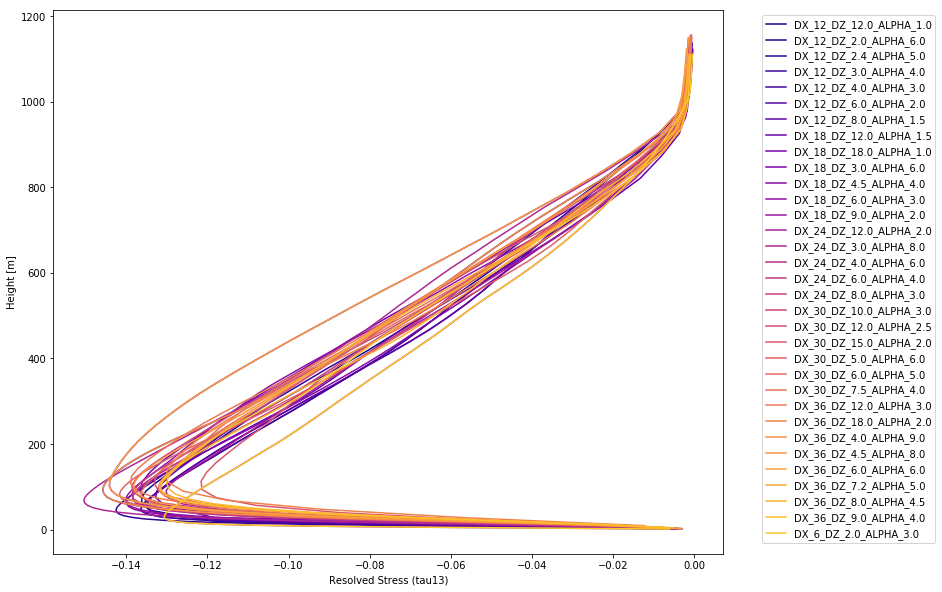

In [164]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

pre_idx=np.argsort(prefixed1)

for tt in range(0, len(ds_1hr)):
    ax.plot( ds_1hr[pre_idx[tt]].isel(XTIME = 0).tau13, ds_1hr[pre_idx[tt]].z , c = case_colormap[tt], label=f'{prefixed1[pre_idx[tt]][19:-3]}' )
    
ax.set_xlabel('Resolved Stress (tau13)')
ax.set_ylabel('Height [m]')
ax.legend(bbox_to_anchor=(1.05, 1))


### Spectra

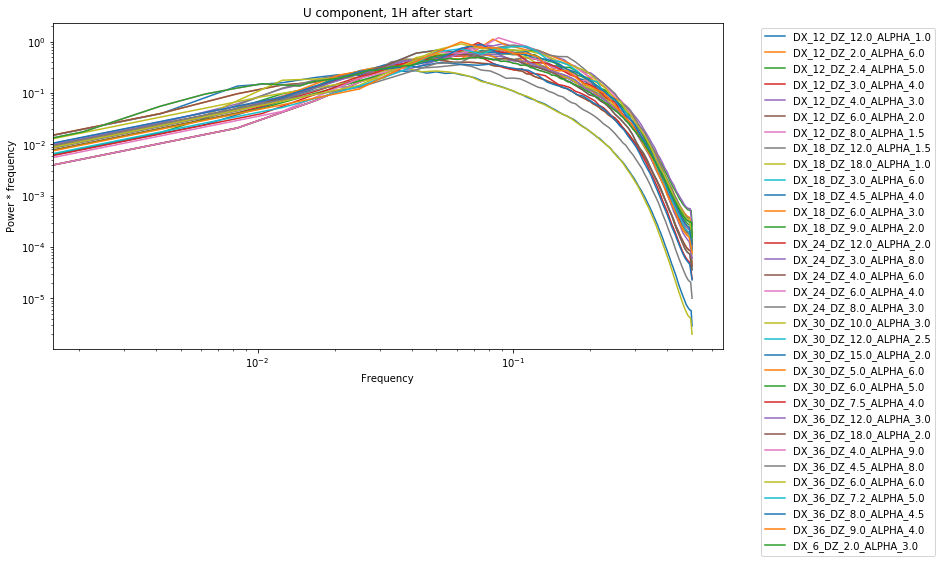

In [173]:
#Spectra after one hour a function of cases

f, ax  = plt.subplots(figsize = ( 12, 6) )

z_spectra=0 #first level

pre_idx=np.argsort(prefixed2)
a=pre_idx[0], b=pre_idx[-1]
for tt in range(0, len(ds_1hr)): 
    z_spectra = psd_ds_1hr[tt].z.isel(XTIME = 0)
    psd_ds_1hr[pre_idx[tt]]['U_p_norm_power'] = psd_ds_1hr[pre_idx[tt]].U_p * psd_ds_1hr[pre_idx[tt]].frequency
    psd_ds_1hr[pre_idx[tt]]['W_p_norm_power'] = psd_ds_1hr[pre_idx[tt]].W_p * psd_ds_1hr[pre_idx[tt]].frequency
    ax.plot(psd_ds_1hr[pre_idx[tt]].frequency, psd_ds_1hr[pre_idx[tt]].U_p_norm_power.isel(XTIME = 0, nz = 0),label=f'{prefixed2[pre_idx[tt]][24:-3]}')

ax.set_ylabel('Power * frequency')    
ax.set_xlabel('Frequency')

ax.set_title(f"U component, {delta_t} after start")

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(bbox_to_anchor=(1.05, 1))


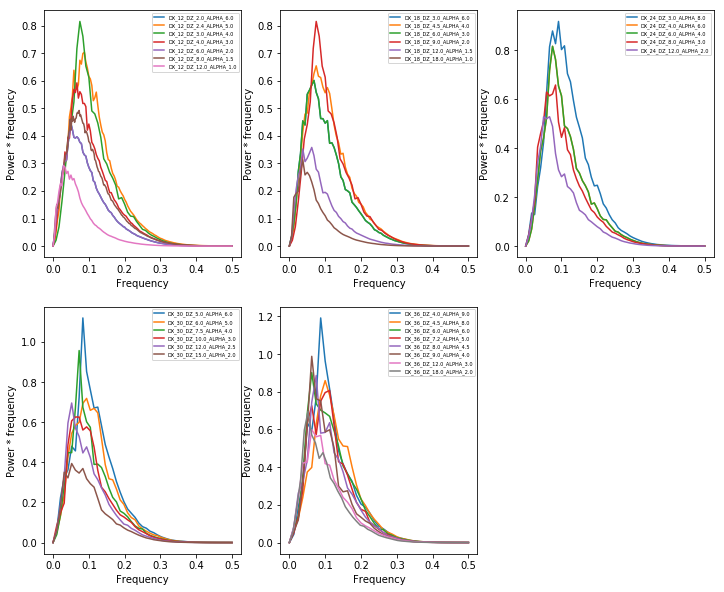

In [194]:
# Tau13 vertical profile, color a function of cases (one hour average)
f, ax = plt.subplots( figsize = (12, 10) )

DX=[12,18,24,30,36]
#DX=[6,12,18,24,30,36]!!!!!!!!!!!!!!!!!!!!!!!!!!!! Cannot process DX=6 here, not enough memmory processed manually

DZ=['2.0','2.4','3.0','4.0','4.5','5.0','6.0','7.2','7.5','8.0','9.0','10.0','12.0','15.0','18.0']

case_colormap = plt.cm.plasma(np.linspace(0, 1, np.int(0.5*len(DX)*len(DZ)) ))

case=[]
p=0
q=0
for dx in DX:
    p=p+1
    plt.subplot(2,3,p)
    for dz in DZ:
        delta_t='1H'
        alpha=str(round(dx/np.float(dz),1))
        folder=f'DX_{dx}_DZ_{dz}_ALPHA_{alpha}'
        if os.path.exists(path+folder):
            if os.path.exists(pdata_loc + pdata_3D):
                #print(folder)
                q=q+1
                img=xr.open_dataset(pdata_loc + f'time_average_spectra_{delta_t}_{folder}.nc')
                img['U_p_norm_power'] = img.U_p * img.frequency
                img['W_p_norm_power'] = img.W_p * img.frequency
                plt.plot(img.frequency, img.U_p_norm_power.isel(XTIME = 0, nz = 0),label=f'{folder}')
                plt.legend(fontsize=5)
                plt.ylabel('Power * frequency')    
                plt.xlabel('Frequency')

